# Loading Covid data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import os
import re
import sys
import time
import yaml
import dateutil.parser
from datetime import date, datetime, timedelta
from pprint import pprint as pp
import numpy as np
import pandas as pd

from pyathena import connect
from elasticsearch import Elasticsearch

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import matplotlib.dates as mdates
import zipfile

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sys.path.insert(0, r'..')

In [2]:
from src.config import DATA_FOLDER

In [3]:
GLOBAL_CONF = 'global-src-confirmed.csv'
GLOBAL_DEAD = 'global-src-deaths.csv'
GLOBAL_REC = 'global-src-recovered.csv'

In [4]:
df_glo_conf = pd.read_csv(DATA_FOLDER.joinpath(GLOBAL_CONF))
df_glo_dead = pd.read_csv(DATA_FOLDER.joinpath(GLOBAL_DEAD))
df_glo_rec = pd.read_csv(DATA_FOLDER.joinpath(GLOBAL_REC))

In [5]:
df_glo_conf.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,40,40,74,84,94,110,110,120,170,174
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,89,104,123,146,174,186,197,212,223,243
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,201,230,264,302,367,409,454,511,584,716
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,113,133,164,188,224,267,308,334,370,376
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,3,3,3,4,4,5,7,7,7


In [6]:
is_date = re.compile(r'[\d]{1,2}/[\d]{1,2}/[\d]{1,4}')

def as_time_series(data):
    if 'Province/State' in data.columns:
        data.set_index('Province/State', inplace=True)
        
    counter = 0
    for d in data.columns:
        if isinstance(d, str):
            if is_date.match(d):
                break
            else:
                counter += 1
#     print(f"Counter: {counter}")
            
    output = data.iloc[:, counter:].copy()
    if isinstance(output.columns[0], datetime):
        return output
    else:
        output.columns = [dateutil.parser.parse(d) for d in output.columns]
        return output

In [7]:
def get_total(df, column='total'):
    return pd.DataFrame({column: df.sum(axis=1)}, index=df.index)

In [8]:
def get_country(name='Spain'):
    data_conf = as_time_series(df_glo_conf[df_glo_conf['Country/Region'] == name]).transpose()
    data_dead = as_time_series(df_glo_dead[df_glo_dead['Country/Region'] == name]).transpose()
    data_rec = as_time_series(df_glo_rec[df_glo_rec['Country/Region'] == name]).transpose()
    
    return (pd.concat([get_total(data_conf, 'confirmed'), 
                       get_total(data_dead, 'dead'), 
                       get_total(data_rec, 'recovered')], axis=1), 
            [data_conf, data_dead, data_rec])

In [9]:
df_sp, full_array = get_country('Spain')
df_sp.tail(5)

,confirmed,dead,recovered
2020-03-27,65719,5138,9357
2020-03-28,73235,5982,12285
2020-03-29,80110,6803,14709
2020-03-30,87956,7716,16780
2020-03-31,95923,8464,19259


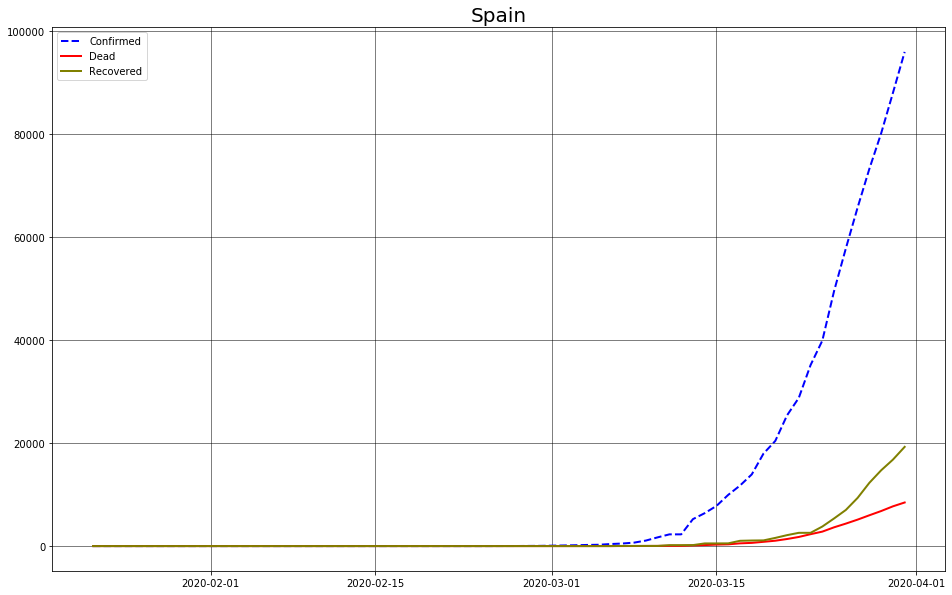

In [10]:
fig = plt.figure(figsize=(16, 10))
# ax = fig.add_subplot(1, 1, 1)
# ax.set_yscale('log')
plt.plot('confirmed', data=df_sp, marker='', color='blue', linewidth=2, linestyle='dashed', label="Confirmed")
plt.plot('dead', data=df_sp, marker='', color='red', linewidth=2, label="Dead")
plt.plot('recovered', data=df_sp, marker='', color='olive', linewidth=2, label="Recovered")
plt.grid(color='black', linestyle='-', linewidth=0.5)

plt.legend()
plt.title("Spain", fontsize=20);

In [11]:
df_australia, full_aus = get_country('Australia')

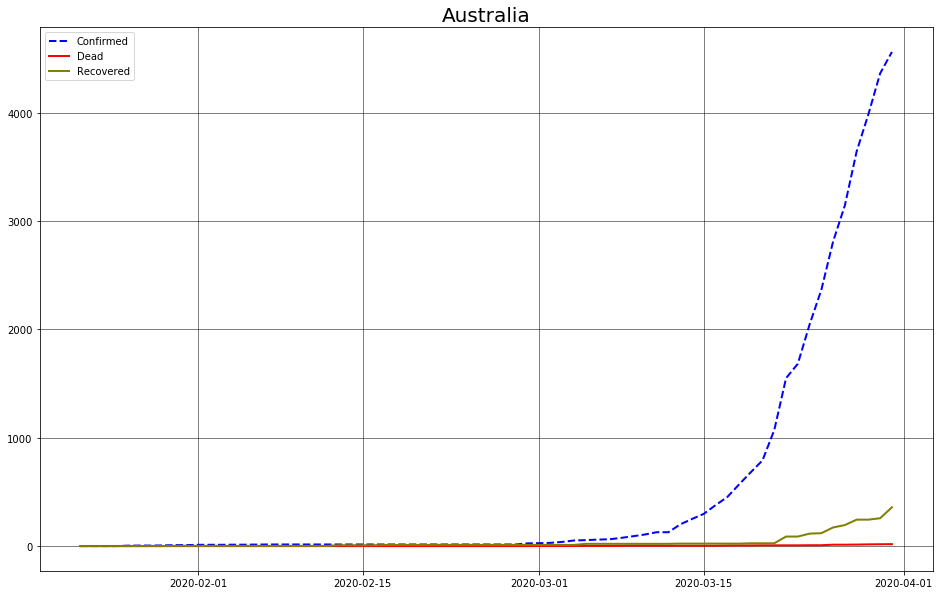

In [12]:
fig = plt.figure(figsize=(16, 10))
# ax = fig.add_subplot(1, 1, 1)
# ax.set_yscale('log')
plt.plot('confirmed', data=df_australia, marker='', color='blue', linewidth=2, linestyle='dashed', label="Confirmed")
plt.plot('dead', data=df_australia, marker='', color='red', linewidth=2, label="Dead")
plt.plot('recovered', data=df_australia, marker='', color='olive', linewidth=2, label="Recovered")
plt.grid(color='black', linestyle='-', linewidth=0.5)

plt.legend()
plt.title("Australia", fontsize=20);

In [13]:
from ipywidgets import *

In [14]:
@interact
def country_plot(country=df_glo_conf['Country/Region'].unique().tolist()):
    
    df, full = get_country(country)
    
    fig, ax = plt.subplots(figsize=(16, 8), ncols=1)
    ax.plot('confirmed', data=df, marker='', color='blue', linewidth=2, linestyle='dashed', label="Confirmed")
    ax.plot('dead', data=df, marker='', color='red', linewidth=2, label="Dead")
    ax.plot('recovered', data=df, marker='', color='olive', linewidth=2, label="Recovered")
    ax.grid(color='grey', linestyle='-', linewidth=0.5)
    ax.tick_params(axis='x', rotation=65)

    ax.legend()
    ax.set_title(country, fontsize=20);

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

In [15]:
@interact
def country_plot(country=df_glo_conf['Country/Region'].unique().tolist()):
    
    df, full = get_country(country)
    # Get the new cases per day
    df = df.diff(1)
    
    column = [('confirmed', 'blue'), ('dead', 'red'), ('recovered', 'green')]
    fig, ax = plt.subplots(figsize=(16, 4), ncols=3)
    
    for idx, x in enumerate(ax):
        x.bar(df.index, df[column[idx][0]], color=column[idx][1])
        x.grid(color='grey', linestyle='-', linewidth=0.5)
        x.set_title(f"{country} {column[idx][0]}", fontsize=14);
        x.tick_params(axis='x', rotation=65)
        x.set_xlabel("Date")

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…